# Incorporating All Sites

## Loading Data

In [1]:
import json
import requests

In [2]:
def run_query(query): # A simple function to use requests to make the API call. Returns json content from query.
    request = requests.get('https://my.es.net/graphql', json={'query': query})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

In [3]:
def query_edge(edge_id, beginTime, endTime):
    query = '''
    {
      mapTopologyEdge(id: "%s") {
            name
        traffic(beginTime: "%s", endTime: "%s")
      }
    }
    ''' % (edge_id, beginTime, endTime)
    
    return  run_query(query)

In [4]:
#Get IDs of all edges in site graph

query_ids = '''
{
  mapTopology(name: "routed_toplevel") {
    edges {
      name
      id
    }
  }
}
'''

result_ids = run_query(query_ids)
print(json.dumps(result_ids, indent=1))

{
 "data": {
  "mapTopology": {
   "edges": [
    {
     "name": "CHIC--STAR", 
     "id": "1767"
    }, 
    {
     "name": "ATLA--NASH", 
     "id": "1747"
    }, 
    {
     "name": "ALBQ--DENV", 
     "id": "1733"
    }, 
    {
     "name": "ALBQ--ELPA", 
     "id": "1734"
    }, 
    {
     "name": "ALBQ--KCP-ALBQ", 
     "id": "1735"
    }, 
    {
     "name": "ALBQ--LANL", 
     "id": "1736"
    }, 
    {
     "name": "ALBQ--SNLA", 
     "id": "1737"
    }, 
    {
     "name": "AMES--STAR", 
     "id": "1738"
    }, 
    {
     "name": "AMST--LOND", 
     "id": "1741"
    }, 
    {
     "name": "AOFA--NEWY", 
     "id": "1744"
    }, 
    {
     "name": "AOFA--STAR", 
     "id": "1745"
    }, 
    {
     "name": "AOFA--WASH", 
     "id": "1746"
    }, 
    {
     "name": "DENV--NGA-SW", 
     "id": "1771"
    }, 
    {
     "name": "ATLA--ORNL", 
     "id": "1748"
    }, 
    {
     "name": "ATLA--WASH", 
     "id": "1751"
    }, 
    {
     "name": "BNL--NEWY", 
     "id": "175

## Process Data

In [5]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
%matplotlib inline

Store mapping of IDs to edge names in a local dictionary

In [6]:
def clean_alledge_data(json_data):
    cleaned_result = json_data['data']['mapTopology']['edges']
    edge_dict = {}
    for item in cleaned_result:
        edge_dict[str(item['id'])] = str(item['name'])
    return edge_dict

edge_dict = clean_alledge_data(result_ids)
edge_names = pd.DataFrame.from_dict(edge_dict, orient='index')
edge_names.columns = ['Name']
edge_names.head()

,Name
1788,JLAB--WASH
1789,KANS--KCP
1780,ELPA--SUNN
1779,ELPA--HOUS
1782,FNAL--STAR


Separate site labels for an edge into two columns

In [7]:
edges = pd.DataFrame(edge_names.Name.str.split('--',1).tolist(), columns = ['From','To'])
edges['ID'] = edge_names.index
edges.head()

,From,To,ID
0,JLAB,WASH,1788
1,KANS,KCP,1789
2,ELPA,SUNN,1780
3,ELPA,HOUS,1779
4,FNAL,STAR,1782


Group individual sites

In [8]:
edges_grouped = edges.groupby("To").agg(list)
edges_grouped

,From,ID
To,,
BOST,[AMST],[1739]
CERN-513,"[CERN, AMST]","[1764, 1740]"
CERN-773,"[CERN, CERN-513]","[1763, 1760]"
DENV,"[ALBQ, BOIS]","[1733, 1753]"
ELPA,[ALBQ],[1734]
EQX-CHI,"[CHIC, EQX-ASH]","[1822, 1823]"
ETTP,[ATLA],[1781]
HOUS,[ELPA],[1779]
INL,[BOIS],[1754]


Function to clean data for a single edge

In [9]:
#Clean data for single edge

def clean_edge_data(json_data):
    #get "traffic" label from json data
    traffic = str(json_data['data']['mapTopologyEdge']['traffic'])

    #get index of "points" label
    index = traffic.find("points")

    #get "points" data
    in_out = traffic[index+len("points: "):].split("],")
    points = [str(item).strip().replace("[", "").replace("]", "").replace(",", "").split() for item in in_out]
    points = points[0:len(points)-1]

    #get labels of points data (ex. CHIC--STAR, STAR--CHIC)
    labels = traffic[traffic.find("labels")+len("labels: "):].split("],")[0].replace("[", 
                                            "").replace("]", "").replace(",", "").replace('"', "").strip().split()
    #Add "Time" to list for header in DataFrame
    labels = ["Time"] + labels
    
    #Create DataFrame
    df = pd.DataFrame(points, columns=labels)
    df = df.astype('float')
    df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x/1000.))
    
    return df

Function to add up all incoming data for a specific site

In [10]:
def add_incoming_data(siteName, startTime, endTime):
    incoming_edges = edges_grouped.loc[siteName]['ID']
    sites_from = edges_grouped.loc[siteName]['From']
    siteNameData = pd.DataFrame({})
    for index in range(len(incoming_edges)):
        query = query_edge(incoming_edges[index], startTime, endTime)
        edgeData = clean_edge_data(query)
        if 'Time' not in siteNameData.columns:
            siteNameData['Time'] = edgeData['Time']
        siteNameData[sites_from[index]+"--"+siteName] = edgeData[sites_from[index]+"--"+siteName]
    return siteNameData

Choose random site (with more than 1 incoming site) and add all incoming traffic data for site

In [14]:
randomSite = edges_grouped[edges_grouped['From'].apply(len) > 1].index[np.random.randint(edges_grouped.shape[0])]
rand_edge_data = add_incoming_data(randomSite, "2018-05-17T18:22:53.253Z", "2018-05-21T19:22:53.253Z")
rand_edge_data.head()

,Time,BOST--NEWY,BNL--NEWY,LOND--NEWY,AOFA--NEWY
0,2018-05-17 18:22:30,2.658521e+09,1.125001e+10,1.449157e+09,1.080383e+10
1,2018-05-17 18:23:00,3.034361e+09,1.140578e+10,1.550998e+09,9.636812e+09
2,2018-05-17 18:23:30,2.208758e+09,1.047873e+10,1.663839e+09,8.548428e+09
3,2018-05-17 18:24:00,2.322215e+09,1.005950e+10,1.686910e+09,9.554211e+09
4,2018-05-17 18:24:30,3.203822e+09,1.013703e+10,1.541164e+09,8.889999e+09


Choose specific site

In [11]:
chosenSite = 'NEWY'
chosen_edge_data = add_incoming_data(chosenSite, "2018-05-17T18:22:53.253Z", "2018-05-21T19:22:53.253Z")
chosen_edge_data.head()

,Time,BOST--NEWY,BNL--NEWY,LOND--NEWY,AOFA--NEWY
0,2018-05-17 18:22:30,2.658521e+09,1.125001e+10,1.449157e+09,1.080383e+10
1,2018-05-17 18:23:00,3.034361e+09,1.140578e+10,1.550998e+09,9.636812e+09
2,2018-05-17 18:23:30,2.208758e+09,1.047873e+10,1.663839e+09,8.548428e+09
3,2018-05-17 18:24:00,2.322215e+09,1.005950e+10,1.686910e+09,9.554211e+09
4,2018-05-17 18:24:30,3.203822e+09,1.013703e+10,1.541164e+09,8.889999e+09


In [12]:
sum_data = chosen_edge_data.drop('Time', axis = 1).sum(axis = 1)
total_data = pd.DataFrame({'Time': chosen_edge_data['Time'], 'Total Incoming Traffic': sum_data})
total_data.head()

,Time,Total Incoming Traffic
0,2018-05-17 18:22:30,2.616152e+10
1,2018-05-17 18:23:00,2.562795e+10
2,2018-05-17 18:23:30,2.289976e+10
3,2018-05-17 18:24:00,2.362284e+10
4,2018-05-17 18:24:30,2.377201e+10


## Model

In [13]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, model_from_json, Model
from keras.layers import Dense, LSTM, Activation, Dropout, Bidirectional, TimeDistributed, RepeatVector, Input, GRU
#from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
#from keras.utils import multi_gpu_model
from random import uniform
import json
# Fix AttributeError: 'module' object has no attribute 'control_flow_ops'
import tensorflow
from tensorflow.python.ops import control_flow_ops
tensorflow.control_flow_ops = control_flow_ops

Using TensorFlow backend.


In [14]:
def inverse_transform(pred, traffic_scaler):    
    return traffic_scaler.inverse_transform(pred)

In [15]:
def train_test_multistepnew(df, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    #Split features from response variable
    X = df[['Total Incoming Traffic']].as_matrix()
    X = scaler.fit_transform(X)
    
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    #Train-test split
    row = int(round(split_proportion * df.shape[0]))
    
    #Train Data
    for index in range(row): 
        X_train.append(X[index: index + seq_len_x]) 
        Y_train.append(np.flip(X[index: index + seq_len_x], axis = 0)) #revese target
    
    #Test Data
    for index in range(row + seq_len_x, X.shape[0] - (seq_len_x + seq_len_y + 1)): 
        X_test.append(X[index: index + seq_len_x]) #adding CHIC--STAR
        Y_test.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    X_train = np.array(X_train)
    X_train = X_train.reshape(X_train.shape[0], X_train[0].shape[0])
    Y_train = np.array(Y_train)
    Y_train = Y_train.reshape(Y_train.shape[0], Y_train[0].shape[0])
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], X_test[0].shape[0])
    Y_test = np.array(Y_test)
    Y_test = Y_test.reshape(Y_test.shape[0], Y_test[0].shape[0])

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 1))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_multistepnew(total_data, 0.87, 20, 20, scaler, traffic_scaler)

X_train shape:  (10128, 20, 1)
Y_train shape:  (10128, 20, 1)
X_test shape:  (1452, 20, 1)
Y_test shape:  (1452, 20, 1)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [17]:
batch_size = 24
nb_epoch = 500

model_totaldata_reversed = Sequential()
model_totaldata_reversed.add(LSTM(input_dim = 1, output_dim=150, return_sequences=False))
model_totaldata_reversed.add(RepeatVector(20)) #seq_len_y
model_totaldata_reversed.add(LSTM(output_dim=150, return_sequences=True))
model_totaldata_reversed.add(LSTM(output_dim=150, return_sequences=True))
model_totaldata_reversed.add(TimeDistributed(Dense(1))) 

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, return_sequences=False, input_shape=(None, 1))`
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, return_sequences=True)`
  import sys
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, return_sequences=True)`
  


In [22]:
print("-- Building --")
model_totaldata_reversed.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_totaldata_reversed.fit(X_train, Y_train, epochs=1, batch_size=batch_size, shuffle=False)
    model_totaldata_reversed.reset_states()

-- Building --
-- Training --
Epoch 1/1
10128/10128 [==============================] - 35s - loss: 0.0134    
Epoch 1/1
10128/10128 [==============================] - 35s - loss: 0.0044    
Epoch 1/1
10128/10128 [==============================] - 36s - loss: 0.0034    
Epoch 1/1
10128/10128 [==============================] - 35s - loss: 0.0027    
Epoch 1/1
10128/10128 [==============================] - 36s - loss: 0.0025    
Epoch 1/1
10128/10128 [==============================] - 35s - loss: 0.0020    
Epoch 1/1
10128/10128 [==============================] - 34s - loss: 0.0025    
Epoch 1/1
10128/10128 [==============================] - 36s - loss: 0.0018    
Epoch 1/1
10128/10128 [==============================] - 36s - loss: 0.0019    
Epoch 1/1
10128/10128 [==============================] - 36s - loss: 0.0017    
Epoch 1/1
10128/10128 [==============================] - 36s - loss: 0.0017    
Epoch 1/1
10128/10128 [==============================] - 36s - loss: 0.0014    
Epoch 1/1


10128/10128 [==============================] - 37s - loss: 5.0366e-05    
Epoch 1/1
10128/10128 [==============================] - 36s - loss: 1.0195e-04    
Epoch 1/1
10128/10128 [==============================] - 36s - loss: 7.1208e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 7.3421e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 4.7275e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 7.9077e-05    
Epoch 1/1
10128/10128 [==============================] - 36s - loss: 9.1453e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 8.9298e-05    
Epoch 1/1
10128/10128 [==============================] - 36s - loss: 5.3227e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 6.2600e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 4.4144e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 8.1704e-05    
Ep

10128/10128 [==============================] - 37s - loss: 3.7691e-05    
Epoch 1/1
10128/10128 [==============================] - 36s - loss: 3.5547e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 1.8132e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 1.2004e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 3.5883e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 1.9235e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 1.9636e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 2.3916e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 3.0943e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 1.7758e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 2.6974e-05    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 2.5499e-05    
Ep

In [18]:
# returns a compiled model
# identical to the previous one
model_totaldata_reversed.load_weights('model_totaldata_reversed.h5')

In [19]:
# walk-forward validation on the test data
pred_x_test = model_totaldata_reversed.predict(X_test, batch_size)
pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0], pred_x_test.shape[1]))
pred_test = inverse_transform(pred_x_test, scaler)

y_test = np.float_(Y_test)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))
y_test_inv = inverse_transform(y_test, scaler)

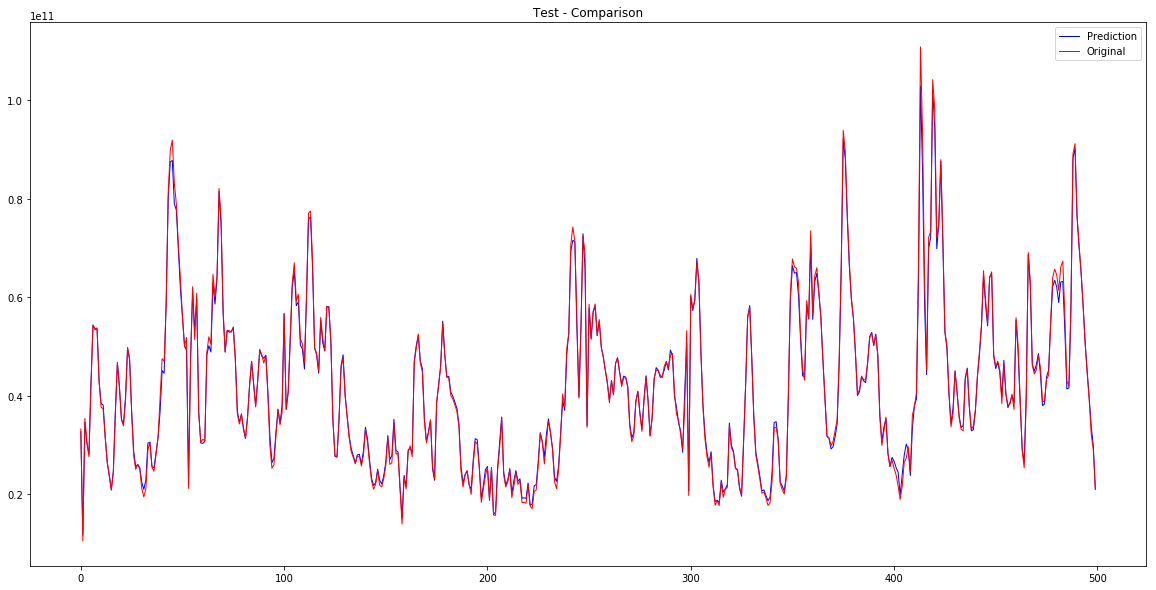

In [29]:
#1 timestep ahead has good prediction

pred_first = [item[19] for item in pred_test][389:889]
y_first = [item[19] for item in y_test_inv][350:850]

# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_first, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison')
plt.show()

In [27]:
from keras.models import load_model

model_totaldata_reversed.save('model_totaldata_reversed.h5')